## 3-2. 線形回帰モデル：線形重回帰モデル

In [1]:
%matplotlib inline

import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sns

sns.set()

### 3.2.1 モデル概要

$$
\begin{align*}
    y_n = \mathbf{w}^\top \mathbf{\phi}(\mathbf{x}_n) + \varepsilon_n
\end{align*}
$$


### 3.2.2 実装

$$
\begin{align*}
    y_n &= w_1 x_{n,1} + w_2 x_{n,2} + w_3 + \varepsilon_n \\
    \varepsilon_n &\sim \mathcal{N}(0, \sigma_{y}^2)
\end{align*}
$$

$w_1, w_2, w_3$ の事前分布は以下とする
$$
\begin{align*}
    \mathbf{w} \sim \mathcal{N}(\mathbf{0}, \sigma_w^2 \mathbf{I})
\end{align*}
$$

テストデータは以下の通り.

In [2]:
# 2次元
dim = 2

# データ数は 4
N = 4

# 真のパラメータ
true_w = np.array([-1.5, 0.8, 1.2]).reshape([3, 1])

# サンプルデータ
rng = np.random.default_rng(seed=1)
x_data = rng.uniform(-5, 5, size=[N, dim])

# バイアスの次元を追加
bias = np.ones(N).reshape([N, 1])
x_data_add_bias = np.concatenate([x_data, bias], axis=1)
y_data = np.dot(x_data_add_bias, true_w) + np.random.normal(0.0, 1.0, size=[N, 1])

In [12]:
with pm.Model() as model:
    # 説明変数
    # shape = (4, 3)
    x = pm.Data("x", x_data_add_bias)

    # 推論パラメータの事前分布
    # 内部では w は (1, 3) ?
    w = pm.Normal("w", mu=0.0, sigma=10.0, shape=3)

    # 尤度関数 (ravel で shape を (4, 1) から (4,) に変換)
    y = pm.Normal("y", mu=w.dot(x.T), sigma=1.0, observed=y_data.ravel())

In [13]:
with model:
    # MCMC による推論
    trace = pm.sample(draws=3000, tune=1000, chains=3, random_seed=1, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [w]


/Users/yuta.sonoda/opt/anaconda3/envs/bayes_ml/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/yuta.sonoda/opt/anaconda3/envs/bayes_ml/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/yuta.sonoda/opt/anaconda3/envs/bayes_ml/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 3 chains for 1_000 tune and 3_000 draw iterations (3_000 + 9_000 draws total) took 11 seconds.


array([[<AxesSubplot:title={'center':'w'}>,
        <AxesSubplot:title={'center':'w'}>]], dtype=object)

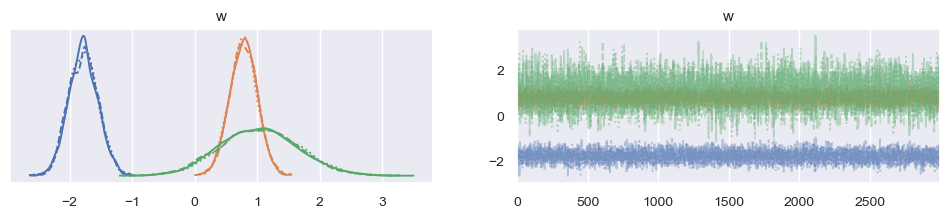

In [14]:
az.plot_trace(trace)

In [15]:
for var_info in az.rhat(trace).values():
    print(var_info.name, var_info.values.round(3), sep=" ")

w [1. 1. 1.]


array([<AxesSubplot:title={'center':'w\n0'}>,
       <AxesSubplot:title={'center':'w\n1'}>,
       <AxesSubplot:title={'center':'w\n2'}>], dtype=object)

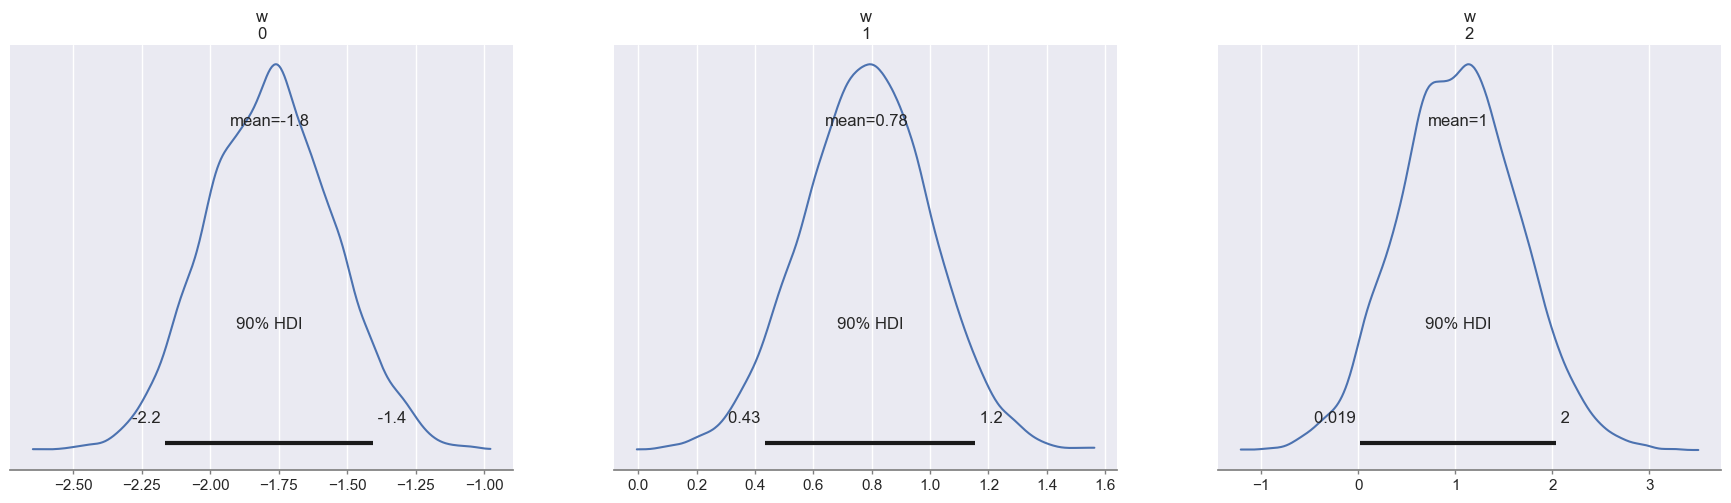

In [16]:
az.plot_posterior(trace, hdi_prob=0.90)

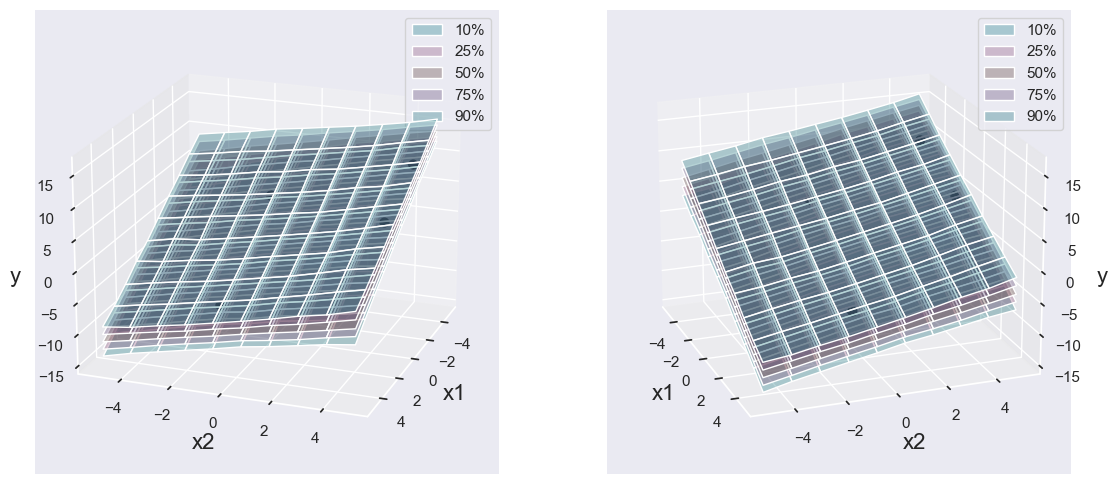

In [35]:
# 検証用データ
x_linspace = np.linspace(-5, 5, 10)
X1, X2 = np.meshgrid(x_linspace, x_linspace)
X_new = np.concatenate([X1.ravel()[:, np.newaxis], X2.ravel()[:, np.newaxis]], axis=1)

# バイアスの次元を追加
X_new_add_bias = np.concatenate([X_new, np.ones(100)[:, np.newaxis]], axis=1)

with model:
    # 検証用データを推論したモデルに入力
    pm.set_data({"x": X_new_add_bias})

    # 予測分布からサンプリング
    pred = pm.sample_posterior_predictive(trace, samples=1000, random_seed=1)

y_pred_samples = pred["y"]

# パーセンタイルごとの超平面を取り出す
Y_10_pred = np.percentile(y_pred_samples, 10, axis=0).reshape(10, 10)
Y_25_pred = np.percentile(y_pred_samples, 25, axis=0).reshape(10, 10)
Y_50_pred = np.percentile(y_pred_samples, 50, axis=0).reshape(10, 10)
Y_75_pred = np.percentile(y_pred_samples, 75, axis=0).reshape(10, 10)
Y_90_pred = np.percentile(y_pred_samples, 90, axis=0).reshape(10, 10)

cmap = plt.get_cmap("tab10")

# 3D 描画用関数
def make_3D_plot(ax, elev, azim):
    surf1 = ax.plot_surface(X1, X2, Y_10_pred, alpha=0.3, color=cmap(7.5), label="10%")
    surf2 = ax.plot_surface(X1, X2, Y_25_pred, alpha=0.3, color=cmap(6), label="25%")
    surf3 = ax.plot_surface(X1, X2, Y_50_pred, alpha=0.3, color=cmap(5), label="50%")
    surf4 = ax.plot_surface(X1, X2, Y_75_pred, alpha=0.3, color=cmap(4), label="75%")
    surf5 = ax.plot_surface(X1, X2, Y_90_pred, alpha=0.3, color=cmap(2.5), label="90%")
    ax.scatter(x_data[:, 0], x_data[:, 1], y_data, alpha=1.0, color="black", s=40)
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel("x1", fontsize=16)
    ax.set_ylabel("x2", fontsize=16)
    ax.set_zlabel("y", fontsize=16)

    surf1._facecolors2d = surf1._facecolor3d
    surf1._edgecolors2d = surf1._edgecolor3d
    surf2._facecolors2d = surf2._facecolor3d
    surf2._edgecolors2d = surf2._edgecolor3d
    surf3._facecolors2d = surf3._facecolor3d
    surf3._edgecolors2d = surf3._edgecolor3d
    surf4._facecolors2d = surf4._facecolor3d
    surf4._edgecolors2d = surf4._edgecolor3d
    surf5._facecolors2d = surf5._facecolor3d
    surf5._edgecolors2d = surf5._edgecolor3d

    ax.legend()


fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(121, projection="3d")
make_3D_plot(ax, 20, 20)

# 別角度から見えるように角度を変えて可視化
ax = fig.add_subplot(122, projection="3d")
make_3D_plot(ax, 20, -20)
plt.tight_layout()
plt.show()